# [IAPR][iapr]: Coin Detection Project


**Group ID:** 56

**Author 1 (sciper):** Shujiro Shobayashi (314853) \\
**Author 2 (sciper):** Camille Pittet (326866)  \\
**Author 3 (sciper):** Renuka Singh Virk (326470)

In [136]:
# Define Access path
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Data_Img_Analysis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.Segmentation

In the initial phase of our coins detection project, we will focus on the segmentation of the coins. This involves localizing each coin in the image and cropping them into uniform-sized images. This standardized set of images will then be used in subsequent phases for feature extraction and classification.

In [137]:
# install these packages before running the script from requirements.txt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from helper_functions import *
from skimage.morphology import *
import cv2

## 1.1 Classification based on Hue channel

Given three distinct types of image backgrounds (neutral, noisy, and hand), we will first distinguish each background type by examining differences in their color features.

In [138]:
# Load the data from the train folder
dir_path = os.path.join("train")
metrics = []
labels = []

# Loop through each directory in the train folder
for d in os.listdir(dir_path):
    labels.append(d)
    dir_data = []

    local_path = os.path.join(dir_path, d)
    for file in os.listdir(local_path):
        file_path = os.path.join(local_path, file)
        image = np.array(Image.open(file_path))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if image is not None:
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

            # Calculate the standard deviation of the hue channel
            hue_std = np.std(hsv[:,:,0].ravel())
            dir_data.append(hue_std)

    metrics.append(dir_data)

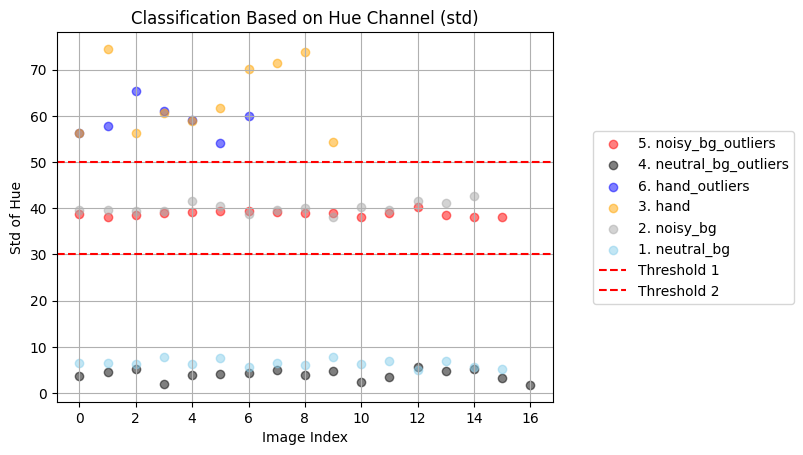

In [145]:
# Plotting for each type of image
colors = ['red', 'black', 'blue', 'orange', 'darkgray', 'skyblue']
fig, ax = plt.subplots()
for metric, color, label in zip(metrics, colors, labels):
    ax.scatter(range(len(metric)), metric, color=color, label=label, alpha=0.5)

# add horizontal lines to show the threshold
ax.axhline(y=50, color='r', linestyle='--', label='Threshold 1')
ax.axhline(y=30, color='r', linestyle='--', label='Threshold 2')

ax.set_xlabel('Image Index')
ax.set_ylabel('Std of Hue')
ax.legend(bbox_to_anchor=(1.5, 0.75), loc='upper right')
plt.title("Classification Based on Hue Channel (std)")
plt.grid()
plt.show()

**Comment:** Each type of image can be separated by selecting different standard hue values. The separation can now be done using the function `project_classify_picture`.


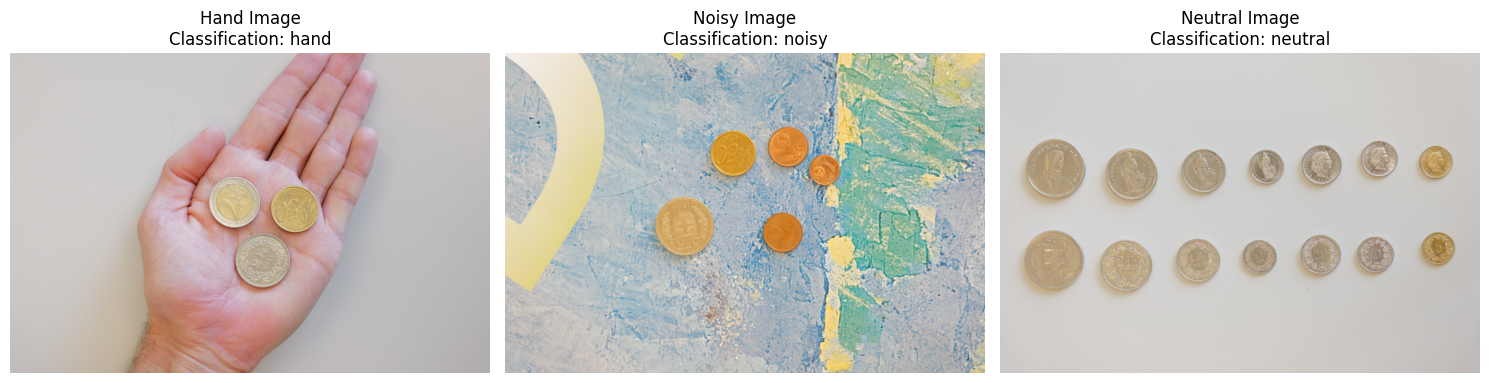

In [5]:
# Example : Classification of a single image

# Load an image
th_hand = 50
th_noisy_low = 30
th_noisy_high = 45

# Image paths for hand, noisy, and neutral images
image_paths = {
    "hand": './train/3. hand/L1010373.JPG',
    "noisy": './train/2. noisy_bg/L1010325.JPG',
    "neutral": './ref/ref_chf.JPG'
}

# Load and classify each image
classified_images = {}
for category, path in image_paths.items():

    # Load image
    image = np.array(Image.open(path))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Classify image
    classification = project_classify_picture(image, th_hand, th_noisy_low, th_noisy_high)
    classified_images[category] = (image, classification)


# Display the images side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (category, (image, classification)) in zip(axes, classified_images.items()):
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title(f"{category.capitalize()} Image\nClassification: {classification}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## 1.2 Image pre-processing
### 1.2.1 Re-sizing & Blurring
To be as quick as possible for the coins detection and to be more efficient as possible, we have first resized the size if provided image and blurred it using the function `project_resize_and_blur_image`.

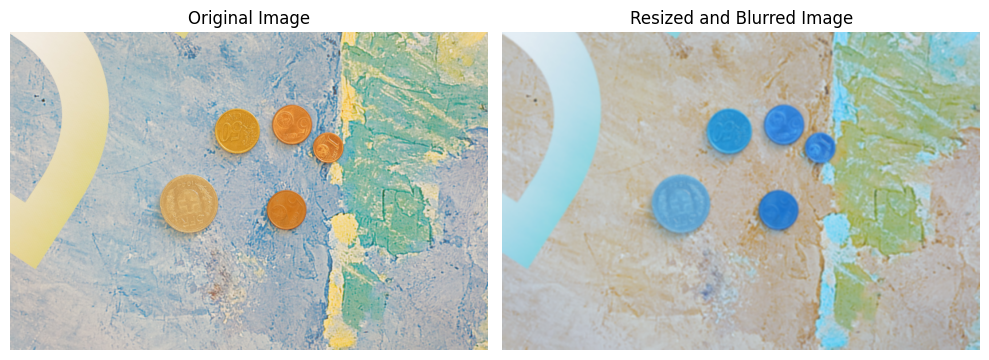

In [6]:
# Example : Resinzing and blurring an image
scale_percent = 10  # Percentage to scale the image
kernel = (3, 3)  # Kernel size for blurring

path = './train/2. noisy_bg/L1010325.JPG'
img_resized_blurred = project_resize_and_blur_image(path, scale_percent, kernel)

# Display the original and the resized and blurred images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Original image
ax[0].imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[0].axis('off')

# Resized and blurred image
ax[1].imshow(cv2.cvtColor(img_resized_blurred, cv2.COLOR_BGR2RGB))
ax[1].set_title('Resized and Blurred Image')
ax[1].axis('off')

plt.tight_layout()
plt.show()


### 1.2.2 Morphology
As we have observed that different types of images can be separated based on their characteristics, we apply various morphological operations to aid in the detection of coins. These operations include thresholding and, where necessary, morphological closing:

1. **Neutral Background**: There is no need for additional morphological operations as all the coins are effectively detected using the cv2.HoughCircles function with its optimal parameters.
2. **Noisy Background**: We apply both thresholding and morphological closing.
3. **Hand Background**: We perform thresholding only.

**Attention**: The HSV values differ for each type of image, which were determined by carefully examining the distributions of HSV values.

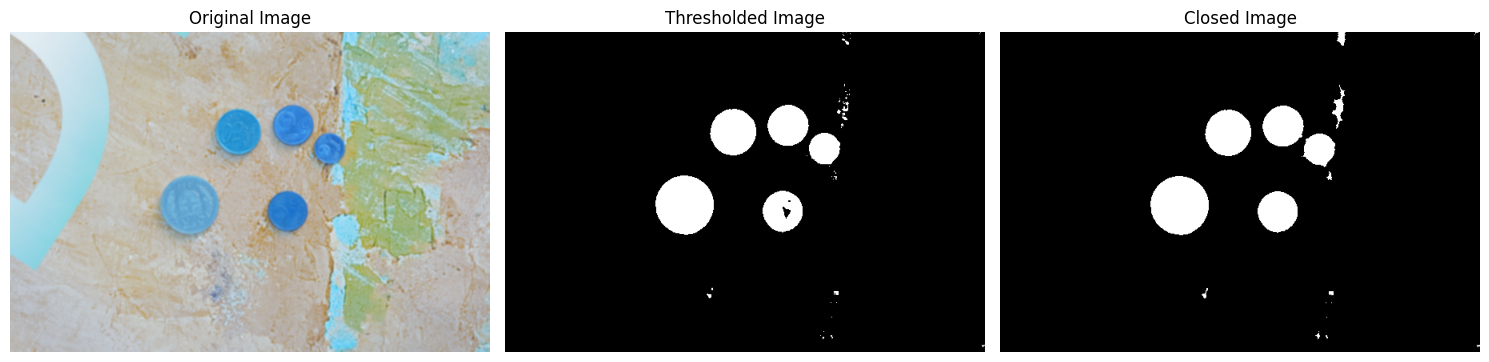

In [7]:
# Example with noisy background image:
path_2 = './train/2. noisy_bg/L1010325.JPG'

hs_values = ((0.0, 0.117), (0.26, 0.85))
disk_size = 5

image = project_resize_and_blur_image(path_2, scale_percent, kernel)
image_th = project_apply_hsv_threshold(image, hs_values)
image_th_closed = apply_closing(image_th,disk_size)

# Display images side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[0].axis('off')

# Thresholded Image
ax[1].imshow(image_th, cmap='gray')
ax[1].set_title('Thresholded Image')
ax[1].axis('off')

# Closed Image
ax[2].imshow(image_th_closed, cmap='gray')
ax[2].set_title('Closed Image')
ax[2].axis('off')

plt.tight_layout()
plt.show()


## 1.3 Detect circles from images
To detect circles in the processed images, we have utilized the function `cv2.HoughCircles()` integrated within our  function `project_detect_and_annotate_circles`. For each type of background, we adjusted the values of Param1 and Param2 to ensure all coins in the training folder are detected:

1. **Neutral Background**: `Param1 = 40` & `Param2 = 20`
2. **Noisy Background**: `Param1 = 20` & `Param2 = 10`
3. **Hand Background**: `Param1 = 30` & `Param2 = 15`

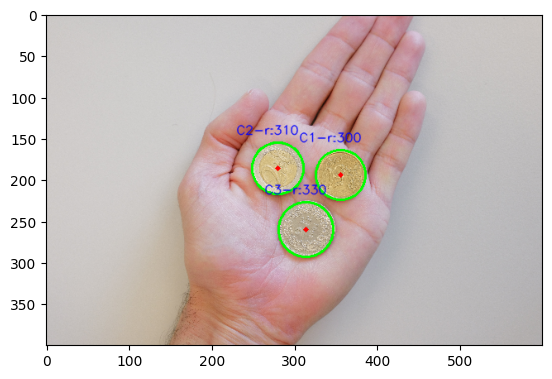

In [8]:
# Example with hand image:
path_3 = './train/3. hand/L1010373.JPG'
# load the image
image = cv2.imread(path_3)

hs_values = ((0.058, 0.58), (0.09, 0.8))

image_r = project_resize_and_blur_image(path_3, scale_percent, kernel)
image_th = project_apply_hsv_threshold(image_r, hs_values)
circles = project_detect_and_annotate_circles(image,
                                              image_th,
                                              scale_percent,
                                              param1=30,
                                              show = True)

## 1.4 Extract Circles with Transparency
Now that we have detected circles in our resized images, we will extract all the circles from the original images to ensure the highest quality for subsequent feature extraction.

The positions of the circles were calculated by multiplying the resized coordinates (x_resized, y_resized) by the scale factor that we previously set.

This task is performed in our function `project_extract_circles_with_transparency`, which allows you to directly save the extracted circles to a directory.

**If you want to save the extracted circles, do not forget to create a folder before and set `save = True` with a directory name (for example, `save_dir = L1010373`) !**


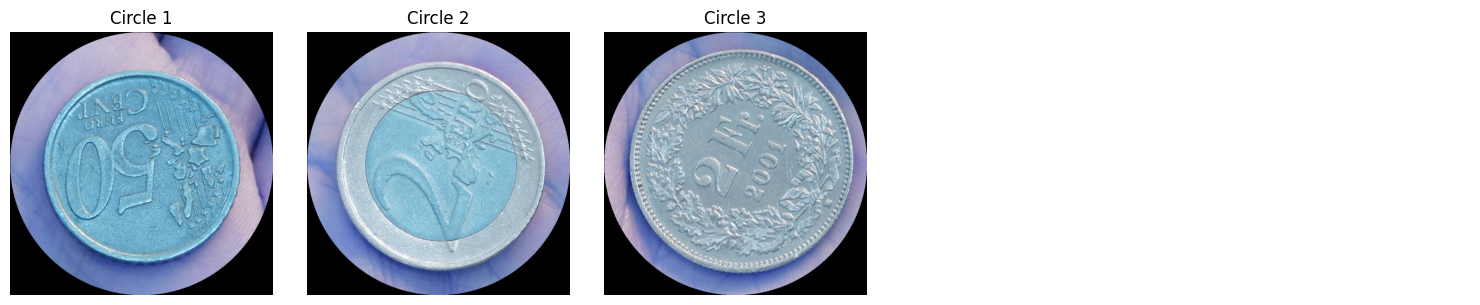

In [130]:
# Example with the previous hand image:

coin_images = project_extract_circles_with_transparency(path_3,
                                          circles,
                                          scale_percent,
                                          show = True)


## 1.5 Final Segmentation
Let's now extract all the circles detected using the methods previously described, by processing every image provided in the training folder, and stock them if you want to (by setting `save = True` in `project_extract_circles_with_transparency`).

**Again, do not forget to define your directory if you want to stock extracted images**.

Here for example, we have created a folder named *'coins_in_train_folder'*

In [ ]:

# Define the list of folders containing your images
folders = ['1. neutral_bg',
           '2. noisy_bg',
           '3. hand',
           '4. neutral_bg_outliers',
           '5. noisy_bg_outliers', '6. hand_outliers']

# Define
scale_percent = 10
kernel = (3,3)
stock = 'coins_in_train_folder' # for example

path = "./train"

# Iterate through each folder
for folder in folders:

    # Get the path to the folder
    folder_path = os.path.join(path, folder)

    # Iterate through each image in the folder
    for filename in os.listdir(folder_path):

        # Check if the file is an image (e.g., ends with '.jpg', '.png', etc.)
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Get the full path to the image
            image_path = os.path.join(folder_path, filename)

            # Load the image using PIL
            original_image = np.array(Image.open(image_path))
            original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)

            # classifying the image
            classification = project_classify_picture(original_image)

            if classification == "hand":
                hs_values = ((0.058, 0.58), (0.09, 0.8))
                image = project_resize_and_blur_image(image_path, scale_percent, kernel)
                image_th = project_apply_hsv_threshold(image, hs_values)

                # detected circles in the image can be seen by setting "show = True"
                detected_circles = project_detect_and_annotate_circles(original_image,
                                                                       image_th,
                                                                       scale_percent,
                                                                       param1=30,
                                                                       show = False)
                project_extract_circles_with_transparency(image_path, detected_circles, scale_percent, save = True, save_dir=stock)

            elif classification == "neutral":
                hs_values = ((0.05, 0.13), (0.2, 0.7))
                image = project_resize_and_blur_image(image_path, scale_percent, kernel)

                # detected circles in the image can be seen by setting "show = True"
                detected_circles = project_detect_and_annotate_circles(original_image,
                                                                       image,
                                                                       scale_percent,
                                                                       param1=40,
                                                                       show = False)
                project_extract_circles_with_transparency(image_path, detected_circles, scale_percent, save = True, save_dir=stock)


            elif classification == "noisy":
                hs_values = ((0.0, 0.117), (0.26, 0.85))
                disk_size = 5
                image = project_resize_and_blur_image(image_path, scale_percent, kernel)
                image_th = project_apply_hsv_threshold(image, hs_values)

                # detected circles in the image can be seen by setting "show = True"
                detected_circles = project_detect_and_annotate_circles(original_image,
                                                                       apply_closing(image_th,disk_size),
                                                                       scale_percent,
                                                                       param1=20,
                                                                       show = False)
                project_extract_circles_with_transparency(image_path, detected_circles, scale_percent, save = True, save_dir=stock)



You can uncomment the following code to apply the same procedure to the images in the test folder.

**Again, do not forget to create a folder named 'coins_in_test_folder' if you want to stock images**

In [ ]:
# Define
scale_percent = 10
kernel = (3,3)
stock = 'coins_in_test_folder'

path = "./test"

# Get the path to the folder
folder_path = os.path.join(path)

# Iterate through each image in the folder
for filename in os.listdir(folder_path):

    # Check if the file is an image (e.g., ends with '.jpg', '.png', etc.)
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        # Get the full path to the image
        image_path = os.path.join(folder_path, filename)

        # Load the image using PIL
        original_image = np.array(Image.open(image_path))
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)

        # classifying the image
        classification = project_classify_picture(original_image)

        if classification == "hand":
            hs_values = ((0.058, 0.58), (0.09, 0.8))
            image = project_resize_and_blur_image(image_path, scale_percent, kernel)
            image_th = project_apply_hsv_threshold(image, hs_values)

            # detected circles in the image can be seen by setting "show = True"
            detected_circles = project_detect_and_annotate_circles(original_image,
                                                                    image_th,
                                                                    scale_percent,
                                                                    param1=30,
                                                                    show = False)
            project_extract_circles_with_transparency(image_path, detected_circles, scale_percent, save_dir=stock)

        elif classification == "neutral":
            hs_values = ((0.05, 0.13), (0.2, 0.7))
            image = project_resize_and_blur_image(image_path, scale_percent, kernel)

            # detected circles in the image can be seen by setting "show = True"
            detected_circles = project_detect_and_annotate_circles(original_image,
                                                                    image,
                                                                    scale_percent,
                                                                    param1=40,
                                                                    show = False)
            project_extract_circles_with_transparency(image_path, detected_circles, scale_percent, save_dir=stock)

        elif classification == "noisy":
            hs_values = ((0.0, 0.117), (0.26, 0.85))
            disk_size = 5
            image = project_resize_and_blur_image(image_path, scale_percent, kernel)
            image_th = project_apply_hsv_threshold(image, hs_values)

            # detected circles in the image can be seen by setting "show = True"
            detected_circles = project_detect_and_annotate_circles(original_image,
                                                                    apply_closing(image_th,disk_size),
                                                                    scale_percent,
                                                                    param1=20,
                                                                    show = False)
            project_extract_circles_with_transparency(image_path, detected_circles, scale_percent, save_dir=stock)


# 2. Feature extraction and Classification
Both of those steps are performed by a CNN, the first layers perform the feature extraction, while the last ones perform classification.

In [15]:
# Change path to Classification folder in which the hand classified coin images are stored
os.chdir('/content/drive/MyDrive/Data_Img_Analysis/Classification')


In [57]:
# Import libraries

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as utils
import torchvision.transforms as transforms
import pandas as pd

from PIL import Image, ImageFilter, ImageEnhance

from torch.utils.data import ConcatDataset, DataLoader
from torchvision.datasets import ImageFolder

### 2.1 Split dataset
Use 80% of data to train and 20% to validate.

In [ ]:

# Set the paths
base_folder = 'Classification'
train_folder = os.path.join(base_folder, 'train')
val_folder = os.path.join(base_folder, 'val')

# List of class folders (excluding 'OOD', 'train', 'val')
class_folders = [
    '0.1CHF', '0.1EUR', '0.01EUR', '0.2CHF', '0.2EUR', '0.02EUR',
    '0.5CHF', '0.05CHF', '0.5EUR', '0.05EUR', '1CHF', '1EUR',
    '2CHF', '2EUR', '5CHF', 'OOD'
]

for class_folder in class_folders:
    # Full paths to the class folders
    source_folder = os.path.join(base_folder, class_folder)
    train_class_folder = os.path.join(train_folder, class_folder)
    val_class_folder = os.path.join(val_folder, class_folder)

    # Ensure the train and val folders for each class exist
    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(val_class_folder, exist_ok=True)

    # Get a list of all .JPG files in the source folder
    files = [f for f in os.listdir(source_folder) if f.lower().endswith('.jpg')]

    # Shuffle the files
    random.shuffle(files)

    # Calculate the split point
    split_point = int(len(files) * 0.8)

    # Split the files
    train_files = files[:split_point]
    val_files = files[split_point:]

    # Move the files to the respective train and val folders
    for file in train_files:
        shutil.move(os.path.join(source_folder, file), os.path.join(train_class_folder, file))

    for file in val_files:
        shutil.move(os.path.join(source_folder, file), os.path.join(val_class_folder, file))

    print(f"Moved {len(train_files)} files to {train_class_folder}")
    print(f"Moved {len(val_files)} files to {val_class_folder}")
    if not os.listdir(source_folder):
        os.rmdir(source_folder)
        print(f"Deleted empty folder: {source_folder}")

print("Data has successfully been split")


\Note: when defining the classes, the labels must be in the same order as the folders in images!

In [21]:
# Define the paths for train and validation directories
train_dir =  'Classification/train'
valid_dir = 'Classification/val'

#name of the classes
# On MAC OS folders are in order
#classes = ("0.1CHF", "0.1EUR", "0.01EUR", "0.2CHF", "0.2EUR", "0.2EUR", "0.5CHF", "0.05CHF", "0.5EUR", "0.05EUR", "1CHF", "1EUR", "2CHF", "2EUR", "5CHF", "OOD")

# Folder order on Google drive
classes = ("0.01EUR", "0.02EUR","0.05CHF", "0.05EUR", "0.1CHF", "0.1EUR", "0.2CHF", "0.2EUR", "0.5CHF", "0.5EUR", "1CHF", "1EUR", "2CHF", "2EUR", "5CHF", "OOD")
NUM_CLASSES = len(classes)
assert(NUM_CLASSES==16)
# batch size
batch_size = 10

## ImageFolder
ImageFolder uses directory structure to determine the class labels.
So we will have the following structure: (manually classified)

```text
images/
|-- train/
|   |-- 0.1CHF/
|   |   |-- ....JPG
|   |   |-- ....jpg
|   |   |-- ...
|   |-- 0.1EUR/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ....JPG
|
|-- val/
|   |-- 0.1CHF/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
|   |-- 0.1EUR/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
```
Note: some coins are more dicy to classify, i.e. the tale CHF coins which are very similar, we thus need to measure the diameter of the coins. Luckily all our images have the same dimensions.
Note also that two images were removed from the train folder (hands with hairs on them)

## 2.2 Preprocessing and ensuring mapping is correct

In [18]:
# Using mean and std from Image Net
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_set = datasets.ImageFolder(train_dir, transform)
valid_set = datasets.ImageFolder(valid_dir, transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

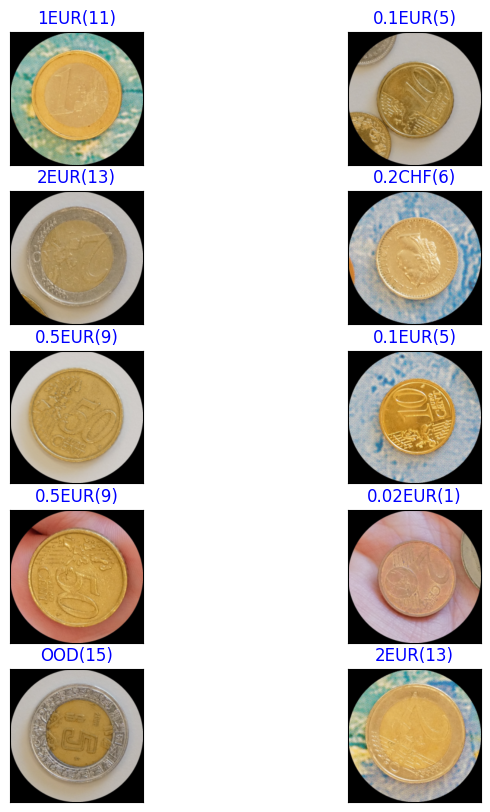

In [22]:
# Visualization of images
def plot_images_from_dataset(images, labels):
    batch_size = images.shape[0]
    fig = plt.figure(figsize=(8, 10))
    for idx in np.arange(int(batch_size)):
        ax = fig.add_subplot(5, int(batch_size/5), idx+1, xticks=[], yticks=[])
        img = np.squeeze(images[idx])
        # revert normalisation
        img = img * np.expand_dims(np.array([0.229, 0.224, 0.225]), (1, 2)) + np.expand_dims(np.array([0.485, 0.456, 0.406]), (1, 2))
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img, (1,2,0)))
        ax.set_title("{}({})".format(classes[labels[idx]],str(labels[idx].item())),
                    color=("blue"))

dataiter = iter(train_loader)
images, labels = next(dataiter)

plot_images_from_dataset(images, labels)

Visualize if mapping is correct

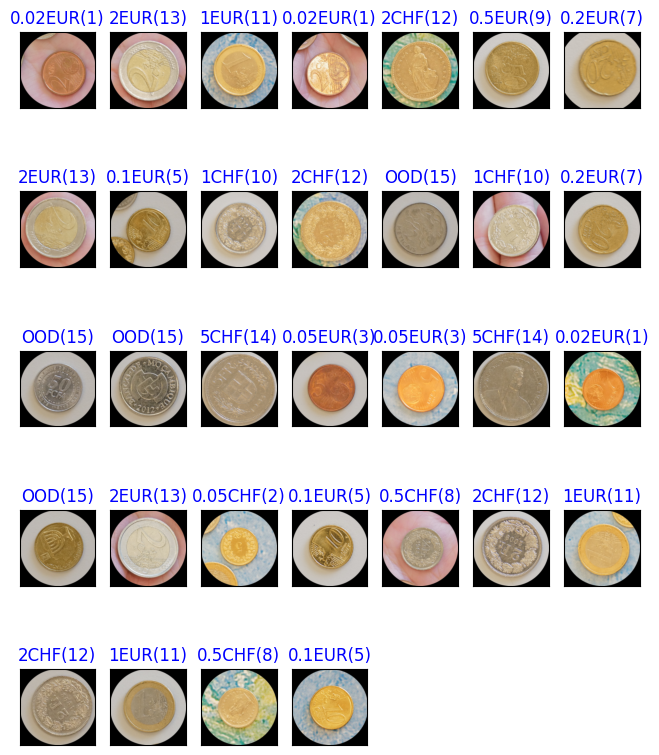

In [23]:
# Define custom mapping
custom_mapping = {
    '0.1CHF': 0,
    '0.1EUR': 1,
    '0.01EUR': 2,
    '0.2CHF': 3,
    '0.2EUR': 4,
    '0.02EUR': 5,
    '0.5CHF': 6,
    '0.05CHF': 7,
    '0.5EUR': 8,
    '0.05EUR': 9,
    '1CHF': 10,
    '1EUR': 11,
    '2CHF': 12,
    '2EUR': 13,
    '5CHF': 14,
    'OOD': 15
}


# Create dataset with custom mapping
train_set = datasets.ImageFolder(train_dir, transform=transform)
valid_set = datasets.ImageFolder(valid_dir, transform=transform)

# Override the class_to_idx mapping with the custom mapping
train_set.class_to_idx = custom_mapping
valid_set.class_to_idx = custom_mapping

# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

# Define a function to plot images from the dataset
def plot_images_from_dataset(images, labels, classes):
    batch_size = images.shape[0]
    rows = 5
    cols = (batch_size + rows - 1) // rows  # Calculate the number of columns
    fig = plt.figure(figsize=(8, 2 * rows))  # Adjust figure size based on rows
    for idx in range(batch_size):
        ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
        img = np.squeeze(images[idx])
        # Revert normalization
        img = img * np.expand_dims(np.array([0.229, 0.224, 0.225]), (1, 2)) + np.expand_dims(np.array([0.485, 0.456, 0.406]), (1, 2))
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img, (1,2,0)))
        ax.set_title("{}({})".format(classes[labels[idx]], str(labels[idx].item())), color=("blue"))

# Get a batch of images and labels from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the images
plot_images_from_dataset(images, labels, train_set.classes)

## Visualize class distribution

how many images in the train set:  299
images per class in dataloader:  {'0.1CHF': 13, '0.02EUR': 18, '0.1EUR': 20, '0.01EUR': 14, '2CHF': 17, 'OOD': 37, '0.05EUR': 24, '2EUR': 25, '5CHF': 22, '0.05CHF': 12, '0.2EUR': 23, '1EUR': 8, '0.2CHF': 9, '0.5EUR': 26, '0.5CHF': 15, '1CHF': 16}


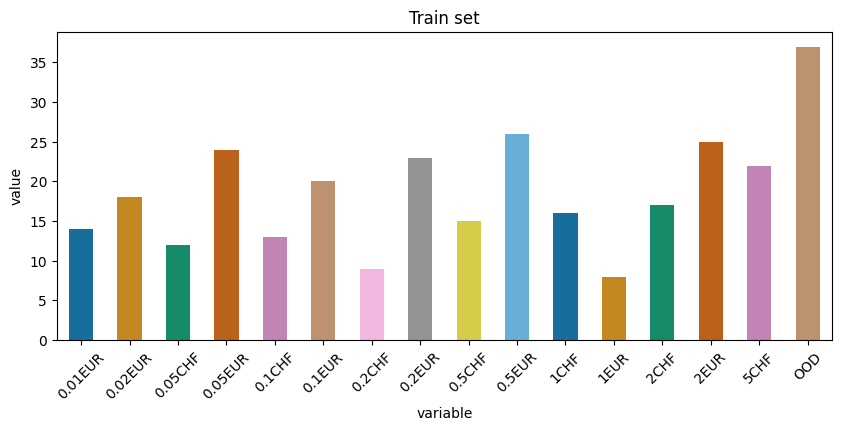

In [24]:
# class distribution
import seaborn as sns
from collections import Counter

print("how many images in the train set: ", len(train_set.targets))


def plot_class_distribution_for_dataloader(dataloader):
# count how many images are outputted by dataloader per class
    count_dict = {}
    for _, target in dataloader:
        for t in target:
            t = classes[int(t)]
            if t not in count_dict:
                count_dict[t] = 0
            count_dict[t] += 1
    print("images per class in dataloader: ", count_dict)
    plt.figure(figsize=(10, 4))
    #plot the class ditribution
    sns.barplot(data=pd.DataFrame.from_dict([count_dict])[list(classes)].melt(),
                  x="variable", y="value", hue="variable", palette="colorblind", width = 0.5,  dodge=False)

    plt.title("Train set")
    plt.xticks(rotation=45)
    plt.legend().set_visible(False)
    plt.show()

plot_class_distribution_for_dataloader(train_loader)
## the training set is perfectly balanced: same number of image for all classes

In the plot above we visualize the class distribution. The classes are not balanced,this is something we should take into accountfor our classifier

### Define metrics: Accuracy and F1-score

In [25]:
from sklearn.metrics import f1_score, accuracy_score
def f1(preds, target):
    return f1_score(target, preds, average='macro')

def acc(preds, target):
    return accuracy_score(target, preds)

### 2.3  Define Model

In [26]:
class CoinNet(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        # Loading AlexNet
        self.model = models.alexnet(pretrained=True)
        # Changing the last layers
        # to reduce the computational complexity we reduce the size of hidden layers
        '''
        self.model.classifier[1] = nn.Linear(9216, 64)
        self.model.classifier[2] = nn.Linear()
        self.model.classifier[4] = nn.Linear(64, 32)
        self.model.classifier[6] = nn.Linear(32, 16)
    '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),            # Add dropout with 50% probability
            nn.Linear(9216, 512),         # Original size to smaller hidden layer
            nn.ReLU(inplace=True),        # ReLU activation
            nn.Dropout(p=0.5),            # Add another dropout layer
            nn.Linear(512, 256),          # Further reduce size of hidden layer
            nn.ReLU(inplace=True),        # ReLU activation
            nn.Dropout(p=0.5),            # Add another dropout layer
            nn.Linear(256, 128),          # Further reduce size of hidden layer
            nn.ReLU(inplace=True),        # ReLU activation
            nn.Linear(128, 16)   # Final layer to match the number of classes
        )
    def freeze_feature_layers(self):
        # Freeze the feature extraction part
        for param in self.model.features:
            param.requires_grad_(False)

    def forward(self, x):
        return self.model(x)

In [35]:
##
from tqdm import tqdm #to see the progress of training
from IPython.display import clear_output



def train_epoch(model, optimizer, criterion, metrics, train_loader, device):
    '''
    device = torch.device('cuda') or torch.device('cpu') if no GPU available
    '''
    model.train()
    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    for batch_num, (x_batch, y_batch) in tqdm(enumerate(train_loader)):
        data = x_batch.to(device)
        target = y_batch.to(device)

        #clean previously computed gradients
        optimizer.zero_grad()

        # forward
        outputs = model(data)

        #compute predictions
        with torch.no_grad():
            _, preds = torch.max(outputs, 1)

        #compute loss
        loss = criterion(outputs, target)

        #do backward and oprimizer steps
        loss.backward()
        optimizer.step()

        # compute metrics
        # no gradients should be propagated at this step
        with torch.no_grad():
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds, target)


        # log loss statistics
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(train_loader)

    clear_output() #clean the prints from previous epochs
    print('train Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [34]:
def evaluate(model, criterion, metrics, test_loader, device):
    model.eval()

    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    # Initialize variables to track the best model
    best_f1 = 0.0

    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        with torch.no_grad(): # we don't compute gradients
            data = x_batch.to(device)
            target = y_batch.to(device)

            #forward
            outputs = model(data)

            #compute loss
            loss = criterion(outputs, target)

            #compute predictions
            _, preds = torch.max(outputs, 1)

            # compute metrics
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds, target)

            # log loss statistics
            epoch_loss += loss.item()


    epoch_loss /= len(test_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(test_loader)

    print('eval Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [29]:
def plot_training(train_loss, test_loss, metrics_names, train_metrics_logs, test_metrics_logs):
    fig, ax = plt.subplots(1, len(metrics_names) + 1, figsize=((len(metrics_names) + 1) * 5, 5))

    ax[0].plot(train_loss, c='blue', label='train')
    ax[0].plot(test_loss, c='orange', label='test')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    for i in range(len(metrics_names)):
        ax[i + 1].plot(train_metrics_logs[i], c='blue', label='train')
        ax[i + 1].plot(test_metrics_logs[i], c='orange', label='val')
        ax[i + 1].set_title(metrics_names[i])
        ax[i + 1].set_xlabel('epoch')
        ax[i + 1].legend()

    plt.show()



In [47]:
def update_metrics_log(metrics_names, metrics_log, new_metrics_dict):
    for i in range(len(metrics_names)):
        curr_metric_name = metrics_names[i]
        metrics_log[i].append(new_metrics_dict[curr_metric_name])
    return metrics_log


def train_cycle(model, optimizer, criterion, metrics, train_loader, test_loader, n_epochs, device):
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]
    best_f1 = 0

    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_loader, device)

        test_loss, test_metrics = evaluate(model, criterion, metrics, test_loader, device)

        train_loss_log.append(train_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

        test_loss_log.append(test_loss)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

        current_f1 = test_metrics_log[1][-1].item()

        if current_f1 > best_f1:
          best_f1 = current_f1
          best_model_wts = model.state_dict()

        plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

    print('Best f1 of:', best_f1, '%')
    return train_metrics_log, test_metrics_log


### 2.4 Training

train Loss: 0.3047,  ACC: 0.8753, F1-weighted: 0.8367
eval Loss: 0.7502,  ACC: 0.8241, F1-weighted: 0.6701
[[tensor(0.2153), tensor(0.2500), tensor(0.3299), tensor(0.3889), tensor(0.5312), tensor(0.4456), tensor(0.6435), tensor(0.5891), tensor(0.6933), tensor(0.6956), tensor(0.6562), tensor(0.7326), tensor(0.7454), tensor(0.7431), tensor(0.7639), tensor(0.7847), tensor(0.8345), tensor(0.8218), tensor(0.8426), tensor(0.8484), tensor(0.7639), tensor(0.8692), tensor(0.7951), tensor(0.8762), tensor(0.8241), tensor(0.9421), tensor(0.8345), tensor(0.8738), tensor(0.8796), tensor(0.8241)], [tensor(0.0774), tensor(0.1359), tensor(0.1692), tensor(0.2323), tensor(0.3018), tensor(0.2656), tensor(0.4084), tensor(0.3767), tensor(0.4659), tensor(0.4946), tensor(0.4898), tensor(0.4972), tensor(0.5500), tensor(0.5581), tensor(0.6141), tensor(0.6255), tensor(0.6287), tensor(0.6511), tensor(0.6143), tensor(0.6649), tensor(0.6779), tensor(0.7289), tensor(0.6412), tensor(0.7212), tensor(0.6202), tensor(0.

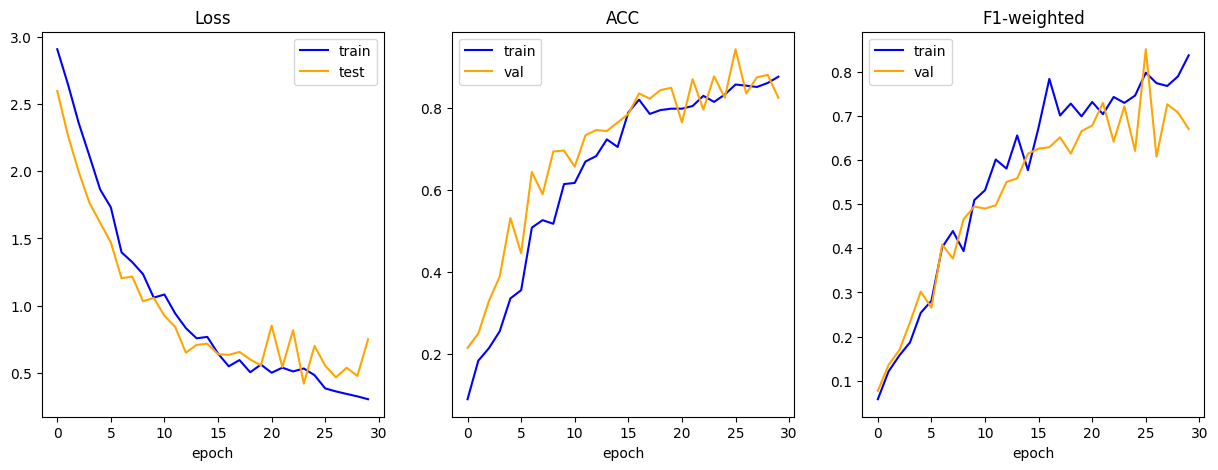

Best f1 of: 0.8504570126533508 %


In [77]:
torch.manual_seed(2)

model = CoinNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

N_EPOCHS = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
# criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_30_epochs.pth')

### Predictions

In [80]:
# Define the transformations for preprocessing the images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of the model
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Function to load the model
def load_model(model_path):
    model = CoinNet(weights="IMAGENET1K_V1")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to make predictions on images
def predict(model, image_folder):
    predictions = {}

    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        image_id = os.path.splitext(image_file)[0]
        image = Image.open(image_path).convert("RGB")
        image = image_transforms(image).unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            predictions[image_id] = predicted.item()

    return predictions

# Load the trained model
model_path = 'models_weights/base_model_30_epochs.pth'
model = load_model(model_path)

# Make predictions on images
test_folder = 'Classification/test'
predictions = predict(model, test_folder)

# Load submission template
sample_submission_path = '/content/drive/MyDrive/Data_Img_Analysis/sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)

# Get class names from the first row of the sample submission file
class_names = sample_submission.columns[1:]

# Iterate over each coin and add its classification to the table
for image_id, pred_idx in predictions.items():
    # Only retrieve image name
    image_name = image_id[-8:]

    # Find corresponding index in sample submission
    index = sample_submission[sample_submission['id'] == image_name].index[0]

    # Get the class name for the predicted index
    class_name = classes[pred_idx]

    # Add coin prediction to corresponding image label
    sample_submission.at[index, class_name] += 1

# Save the updated sample submission
sample_submission.to_csv('predictions30_epoch.csv', index=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Results
We got 85% F1 Score on eval and 82% on Kaggle, to improve predictions will use features augmentation to increase the dataset and to balance classes

# =====================================================

## 2.5 Feature Augmentation
We try:


*   Rotation: Model should be invariant to coin rotation
*   Gaussian blurring: Image quality can vary

*   ColorJitter: Image luminosity can vary

We avoid:
*   RGB, not good since the validation data has the same colors as the train
*   Scaling / croping: not a good idea since once again the coins have a fixed size and are whole \\

Below we visualize the effect of the transforms applied.

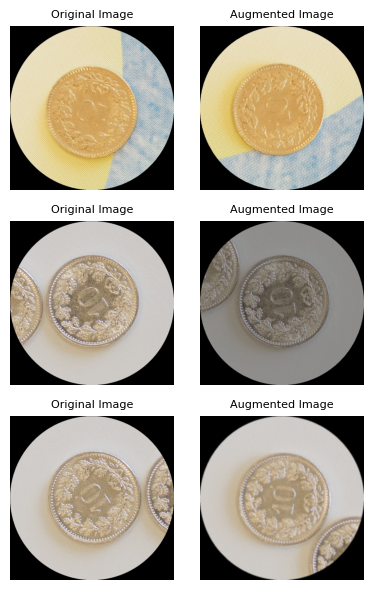

In [76]:

# Define the transformations
random_rotation = transforms.RandomRotation(degrees=(0, 360))
color_jitter = transforms.ColorJitter(brightness=(0.7,1), saturation=(0.5, 1))
gaussian_blur = transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=2)))
contrast_enhancement = transforms.Lambda(lambda img: ImageEnhance.Contrast(img).enhance(1.5))

# Compose transformations with random application
transform = transforms.Compose([
    transforms.RandomApply([random_rotation], p=1),
    transforms.RandomApply([color_jitter], p=0.5),
    transforms.RandomApply([gaussian_blur], p=0.3),
    #transforms.RandomApply([contrast_enhancement], p=0.4),
    transforms.ToTensor(),
])

image_folder = 'Classification/train/0.1CHF'

# Keep 3 example images
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith('.jpg')][:3]



def apply_transformations(image_path):
    image = Image.open(image_path).convert("RGB")
    transformed_image = transform(image)
    transformed_image_pil = transforms.ToPILImage()(transformed_image)
    return image, transformed_image_pil

fig, axs = plt.subplots(len(image_files), 2, figsize=(4, 2 * len(image_files)))

for i, image_file in enumerate(image_files):

    image_path = os.path.join(image_folder, image_file)
    original_image, augmented_image = apply_transformations(image_path)

    # Original image
    axs[i, 0].imshow(original_image)
    axs[i, 0].set_title(f'Original Image', fontsize=8)
    axs[i, 0].axis('off')

    # New transformed image
    axs[i, 1].imshow(augmented_image)
    axs[i, 1].set_title(f'Augmented Image', fontsize=8)
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()



Now that we've visualized that the transformations make sense for our task, we create the following structure:
```text
images/
|-- train/
|   |-- 0.1CHF/
|   |   |-- ....JPG
|   |   |-- ....jpg
|   |   |-- ...
|   |-- 0.1EUR/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ....JPG
|
|-- val/
|   |-- 0.1CHF/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
|   |-- 0.1EUR/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
|-- augmented_train/
|   |-- 0.1CHF/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
|   |-- 0.1EUR/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
```
Here augmented_train contains augmented images from the original training data. The augmented_train folder contains **only** the new images. We then merge the two to train.

In [53]:
train_dir = 'Classification/train'
augmented_train_dir = 'Classification/augmented_train100'
num_images_per_class = 100

# Create augmented_train directory if it doesn't exist
if not os.path.exists(augmented_train_dir):
    os.makedirs(augmented_train_dir)

# Iterate over each class folder in the original training directory
for class_folder in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_folder)
    if not os.path.isdir(class_dir):  # Skip non-directory files like .DS_Store
        continue

    augmented_class_dir = os.path.join(augmented_train_dir, class_folder)

    # Create the augmented class directory if it doesn't exist
    if not os.path.exists(augmented_class_dir):
        os.makedirs(augmented_class_dir)

    # List original images in the class folder
    original_images = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]
    num_original_images = len(original_images)

    # Calculate the number of augmented images needed
    num_augmented_images_needed = max(0, num_images_per_class - num_original_images)

    # Generate augmented images and save them to the augmented class directory
    for i in range(num_augmented_images_needed):
        # Select an original image to augment (loop over original images if needed)
        original_image_name = original_images[i % num_original_images]
        original_image_path = os.path.join(class_dir, original_image_name)

        # Generate an augmented image
        original_image = Image.open(original_image_path)
        augmented_image = transform(original_image)

        # Convert the augmented image back to PIL format
        augmented_image_pil = transforms.ToPILImage()(augmented_image)

        # Save the augmented image
        augmented_image_path = os.path.join(augmented_class_dir, f'augmented_{i}_{original_image_name}')
        augmented_image_pil.save(augmented_image_path)


Let's check the correct number of classes is created and the total amount of pictures per class is the desired one (num_images_per_class):

In [81]:
for class_folder in os.listdir(train_dir):
    class_train_dir = os.path.join(train_dir, class_folder)
    if not os.path.isdir(class_train_dir):  # Skip non-directory files like .DS_Store
        continue

    class_augmented_train_dir = os.path.join(augmented_train_dir, class_folder)

    # Count the number of images in train directory
    num_train_images = len([name for name in os.listdir(class_train_dir) if name.lower().endswith('.jpg')])

    # Count the number of images in augmented_train directory
    num_augmented_train_images = len([name for name in os.listdir(class_augmented_train_dir) if name.lower().endswith('.jpg')])

    # Assert that the sum of images in train and augmented_train directories is equal to num_images_per_class
    assert (num_train_images + num_augmented_train_images) == num_images_per_class, f"Sum of images in train and augmented_train for class {class_folder} should be equal to {num_images_per_class}."


We can now visualize the classes distribution after feature augmentation:

<ipython-input-55-ed3f552a74fa>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=color_palette)


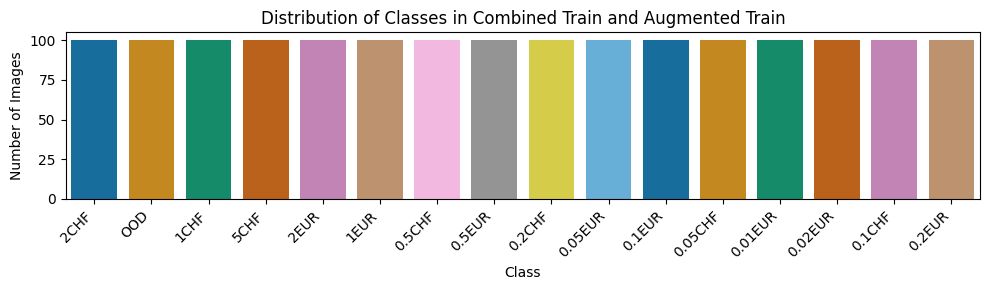

In [55]:
# Initialize a dictionary to store the count of images per class
class_counts = {}

# Count the number of images in each class in the train directory
for class_folder in os.listdir(train_dir):
    class_train_dir = os.path.join(train_dir, class_folder)
    if not os.path.isdir(class_train_dir):  # Skip non-directory files like .DS_Store
        continue

    num_train_images = len([name for name in os.listdir(class_train_dir) if name.lower().endswith('.jpg')])
    class_counts[class_folder] = num_train_images

# Count the number of images in each class in the augmented_train directory
for class_folder in os.listdir(augmented_train_dir):
    class_augmented_train_dir = os.path.join(augmented_train_dir, class_folder)
    if not os.path.isdir(class_augmented_train_dir):  # Skip non-directory files like .DS_Store
        continue

    num_augmented_train_images = len([name for name in os.listdir(class_augmented_train_dir) if name.lower().endswith('.jpg')])
    class_counts[class_folder] = class_counts.get(class_folder, 0) + num_augmented_train_images

# Define color palette
color_palette = sns.color_palette("colorblind", len(class_counts))

# Plot the distribution of classes with the same colors as in the provided code snippet
plt.figure(figsize=(10, 3))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=color_palette)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Combined Train and Augmented Train')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


### Training

In [82]:
train_dataset = ImageFolder(train_dir, transform=transform)
augmented_train_dataset = ImageFolder(augmented_train_dir, transform=transform)
combined_dataset = ConcatDataset([train_dataset, augmented_train_dataset])
combined_train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

# Calculate the total number of images in the augmented training set
total_images = len(combined_dataset)
previous_nbr_images = len(train_dataset)
print("Total number of images before feature augmentation:", previous_nbr_images)
print("Total number of images after feature augmentation:", total_images)

Total number of images before feature augmentation: 299
Total number of images after feature augmentation: 1600


train Loss: 0.2629,  ACC: 0.9097, F1-weighted: 0.8377
eval Loss: 0.5418,  ACC: 0.8762, F1-weighted: 0.7441
[[tensor(0.1574), tensor(0.3322), tensor(0.3194), tensor(0.3831), tensor(0.3935), tensor(0.4537), tensor(0.5417), tensor(0.5891), tensor(0.7037), tensor(0.6458), tensor(0.7569), tensor(0.7766), tensor(0.7407), tensor(0.7755), tensor(0.7963), tensor(0.8056), tensor(0.7847), tensor(0.8692), tensor(0.9005), tensor(0.8403), tensor(0.8634), tensor(0.8634), tensor(0.7847), tensor(0.8275), tensor(0.8183), tensor(0.7847), tensor(0.8692), tensor(0.8715), tensor(0.8588), tensor(0.8762)], [tensor(0.0742), tensor(0.2025), tensor(0.1581), tensor(0.2437), tensor(0.2138), tensor(0.3466), tensor(0.3422), tensor(0.4248), tensor(0.5707), tensor(0.4705), tensor(0.6225), tensor(0.6237), tensor(0.5898), tensor(0.6020), tensor(0.6180), tensor(0.6738), tensor(0.6851), tensor(0.7109), tensor(0.7842), tensor(0.6786), tensor(0.7415), tensor(0.7332), tensor(0.6436), tensor(0.6882), tensor(0.7059), tensor(0.

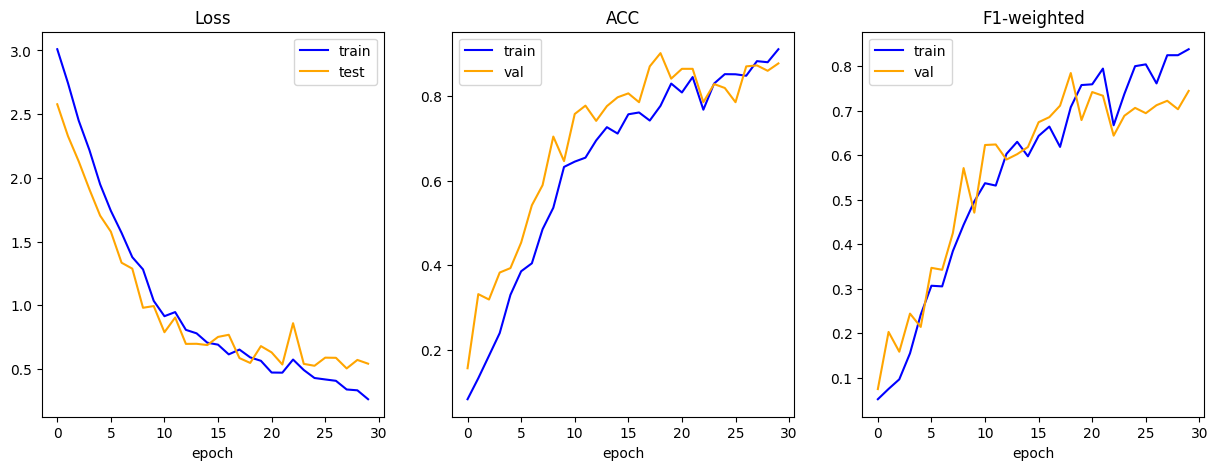

Best f1 of: 0.7842190265655518 %


In [59]:
torch.manual_seed(42)

model = CoinNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

N_EPOCHS = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
# criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model.pth')


## Generate predictions on test set


In [62]:

# Define the transformations for preprocessing the images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of the model
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Function to load the model
def load_model(model_path):
    model = CoinNet(weights="IMAGENET1K_V1")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to make predictions on images
def predict(model, image_folder):
    predictions = {}

    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        image_id = os.path.splitext(image_file)[0]
        image = Image.open(image_path).convert("RGB")
        image = image_transforms(image).unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            predictions[image_id] = predicted.item()

    return predictions

# Load the trained model
model_path = 'models_weights/base_model.pth'
model = load_model(model_path)

# Make predictions on images
test_folder = 'Classification/test'
predictions = predict(model, test_folder)

# Load submission template
sample_submission_path = '/content/drive/MyDrive/Data_Img_Analysis/sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)

# Get class names from the first row of the sample submission file
class_names = sample_submission.columns[1:]

# Iterate over each coin and add its classification to the table
for image_id, pred_idx in predictions.items():
    # Only retrieve image name
    image_name = image_id[-8:]

    # Find corresponding index in sample submission
    index = sample_submission[sample_submission['id'] == image_name].index[0]

    # Get the class name for the predicted index
    class_name = classes[pred_idx]

    # Add coin prediction to corresponding image label
    sample_submission.at[index, class_name] += 1

# Save the updated sample submission
sample_submission.to_csv('predictions_augmented30epoch.csv', index=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Results:
We got 78% F1 Score on eval and 88% on Kaggle. Feature augmentation improved the Kaggle accuracy by 6%

# 3. Example Usage

### 3.1 Extract coins

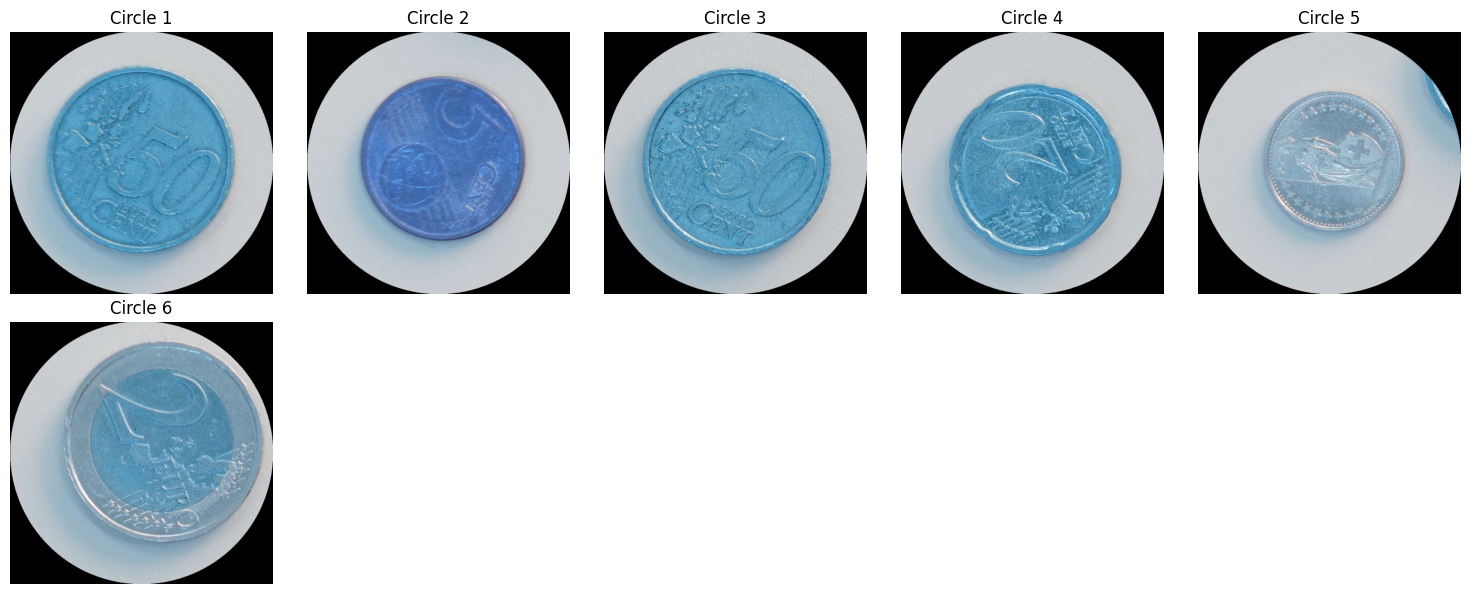

In [131]:
  # Change directory
  os.chdir('/content/drive/MyDrive/Data_Img_Analysis')

  # Path of the image you want to predict
  image_path = '/content/drive/MyDrive/Data_Img_Analysis/train/1. neutral_bg/L1010283.JPG'

  # Load the image using PIL
  original_image = np.array(Image.open(image_path))
  original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)

  # classifying the image
  classification = project_classify_picture(original_image)

  if classification == "hand":
      hs_values = ((0.058, 0.58), (0.09, 0.8))
      image = project_resize_and_blur_image(image_path, scale_percent, kernel)
      image_th = project_apply_hsv_threshold(image, hs_values)

      # detected circles in the image can be seen by setting "show = True"
      detected_circles = project_detect_and_annotate_circles(original_image,
                                                              image_th,
                                                              scale_percent,
                                                              param1=30,
                                                              show = False)


  elif classification == "neutral":
      hs_values = ((0.05, 0.13), (0.2, 0.7))
      image = project_resize_and_blur_image(image_path, scale_percent, kernel)
      #image_th = apply_opening(image_th,disk_size)

      # detected circles in the image can be seen by setting "show = True"
      detected_circles = project_detect_and_annotate_circles(original_image,
                                                              image,
                                                              scale_percent,
                                                              param1=40,
                                                              show = False)



  elif classification == "noisy":
      hs_values = ((0.0, 0.117), (0.26, 0.85))
      disk_size = 5
      image = project_resize_and_blur_image(image_path, scale_percent, kernel)
      image_th = apply_opening(image_th,1)
      image_th = remove_small_objects(image_th, 1)

      # detected circles in the image can be seen by setting "show = True"
      detected_circles = project_detect_and_annotate_circles(original_image,
                                                              apply_closing(image_th,disk_size),
                                                              scale_percent,
                                                              param1=20,
                                                              show = False)
  coins = project_extract_circles_with_transparency(image_path, detected_circles, scale_percent, show=True, save=True, save_dir='/content/drive/MyDrive/Data_Img_Analysis/Example')

### 3.2 Classify coins

In [100]:
# Define the transformations for preprocessing the images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of the model
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Function to load the model
def load_model(model_path):
    model = CoinNet(weights="IMAGENET1K_V1")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to make predictions on images
def predict(model, image_folder):
    predictions = {}

    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        image_id = os.path.splitext(image_file)[0]
        image = Image.open(image_path).convert("RGB")
        image = image_transforms(image).unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            predictions[image_id] = predicted.item()

    return predictions

# Load the trained model
model_path = 'Classification/models_weights/base_model.pth'
model = load_model(model_path)

# Make predictions on images
folder = 'Example'
predictions = predict(model, folder)

# Iterate over each coin and find the corresponding coin label

preds = []
for image_id, pred_idx in predictions.items():
    # Find corresponding index in sample submission
    index = sample_submission[sample_submission['id'] == image_name].index[0]

    # Get the class name for the predicted index
    class_name = classes[pred_idx]
    preds.append(class_name)

print("Predictions:", preds)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predictions: ['0.5EUR', '0.05EUR', '0.5EUR', '0.2EUR', '0.5CHF', '2EUR']


### 3.3 Display Detections and Predictions

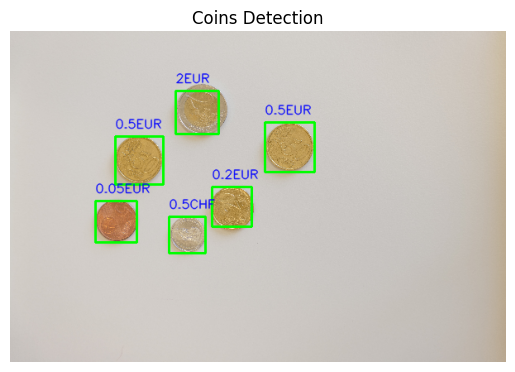

In [115]:
# load the image
image = cv2.imread(image_path)

project_show_image_with_predictions(image, detected_circles, scale_percent, preds, show=True)

On this image all coins are properly detected and labeled!